<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/Lecture14_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 14. VAE

# 1. Library Import

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

import numpy as np
import os, matplotlib
from matplotlib import pyplot as plt

# 2. Dataset Load

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(mnist_digits.shape)

11493376/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1)


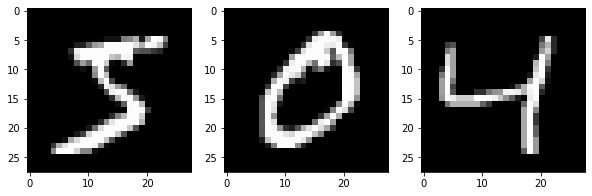

In [5]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(mnist_digits[i][...,0], cmap='gray')

* 하이퍼 파라미터 설정

In [6]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면

# 3. Model Build

## 3.1. 샘플링 함수

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs 
        batch = tf.shape(z_mean)[0] # z_mean layer에서 batch 추출
        dim = tf.shape(z_mean)[1] # z_mean layer에서 필터 수, 즉 dimension 추출
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## 3.2. VAE 인코더 네트워크

In [11]:
encoder_inputs = tf.keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)  # CNN 기본 형태의 Encoder 구간
z_mean = layers.Dense(latent_dim, name="z_mean")(x)  # z_mean 레이어 형태로 추출, 필터 2 -> 2D 잠재공간
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)  # z_log_var 레이어 형태로 추출, 필터 2 -> 2D 잠재공간
z = Sampling()([z_mean, z_log_var])  # 샘플링 함수에 레이어 형태로 삽입
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")  # z_mean, z_log_var, 샘플링 함수 모두 아웃풋으로 받음
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

## 3.3. VAE 디코더 네트워크

In [13]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  # 샘플링 함수로 구한 z값 
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)  # encoder 에서 flatten 레이어와 동일한 파라미터 수
x = layers.Reshape((7, 7, 64))(x)  # flatten 레이어를 다시 2차원 레이어로 변환
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # Transpose Conv2D 레이어로 이미지 확대(strides=2)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # Transpose Conv2D 레이어로 이미지 확대(strides=2)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## 3.4. VAE 최종모델

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )  # 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")  # 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # 인코딩 과정에서 잠재공간에 대한 특성 추출(z_mean, z_log_val, z)
            reconstruction = self.decoder(z)  # 디코딩을 통해 이미지 재구성
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )  # decoder된 결과에 대한 binary cross-entropy -> 원본입력과 똑같도록 재구성 손실
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  # 잠재공간 식(샘플링 함수)에 대한 규제 손실
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)  # 전체 손실(재구성+규제)에 대한 그래디언트 함수
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# 4. Model Training

In [23]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 12s 8ms/step - loss: 253.7994 - reconstruction_loss: 210.5792 - kl_loss: 2.1738
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 189.8206 - reconstruction_loss: 184.5924 - kl_loss: 3.0844
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 181.3740 - reconstruction_loss: 171.3951 - kl_loss: 4.4285
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 164.8716 - reconstruction_loss: 157.5264 - kl_loss: 5.8351
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 160.5561 - reconstruction_loss: 153.5891 - kl_loss: 6.0592
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 158.4221 - reconstruction_loss: 151.6943 - kl_loss: 6.1129
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 156.6389 - reconstruction_loss: 150.1951 - kl_loss: 6.1474
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - 

## 5. Train Result

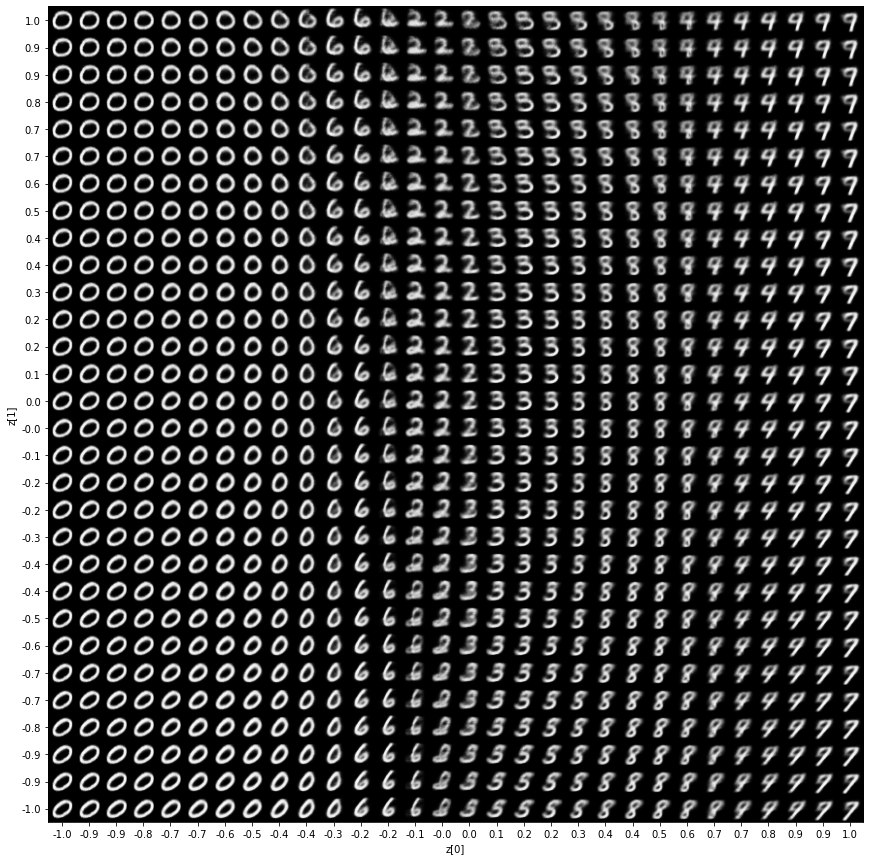

In [24]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)